In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 3

In [4]:
OOF_PATH = Path("../data/oof/lgbm-dart-xtree-bce-dsv02")
SUB_PATH = Path("../data/subs/lgbm-dart-xtree-bce-dsv02")
ART_PATH = Path("../artifacts/lgbm-dart-xtree-bce-dsv02")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
!ls ../data/processed/dsv02

test.parquet  train.parquet


In [6]:
train = pd.read_parquet("../data/processed/dsv02/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [7]:
input_feats = train.columns.tolist()
categ_feats = [
    'B_30_first', 'B_38_first', 'D_114_first', 'D_116_first', 'D_117_first', 
    'D_120_first', 'D_126_first', 'D_63_first', 'D_64_first', 'D_66_first', 'D_68_first',
    'B_30_last', 'B_38_last', 'D_114_last', 'D_116_last', 'D_117_last', 
    'D_120_last', 'D_126_last', 'D_63_last', 'D_64_last', 'D_66_last', 'D_68_last',
]
numeric_feats = [col for col in input_feats if col not in categ_feats]

len(input_feats)

1562

In [8]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [9]:
model_params = {
    'boosting':'dart',
    'extra_trees':True,
    'objective': 'binary',
    'metric': 'None',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_bin': 511,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 0.95,
    'feature_fraction': 0.2,
    'lambda_l1': 10.352308845012756,
    'lambda_l2': 1.569788743184169,
    'min_data_in_leaf': 2000,
    'path_smooth': 30.,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'verbosity': -1,
}

In [10]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True,
        )
        
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=5000,
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [11]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/3 ################################
######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.746737	valid_0's recall_at4: 0.594421	valid_0's norm_gini: 0.899053
[100]	valid_0's amex_metric: 0.757653	valid_0's recall_at4: 0.610368	valid_0's norm_gini: 0.904938
[150]	valid_0's amex_metric: 0.7623	valid_0's recall_at4: 0.617226	valid_0's norm_gini: 0.907374
[200]	valid_0's amex_metric: 0.765817	valid_0's recall_at4: 0.622444	valid_0's norm_gini: 0.909191
[250]	valid_0's amex_metric: 0.768734	valid_0's recall_at4: 0.626525	valid_0's norm_gini: 0.910943
[300]	valid_0's amex_metric: 0.771606	valid_0's recall_at4: 0.630817	valid_0's norm_gini: 0.912394
[350]	valid_0's amex_metric: 0.772751	valid_0's recall_at4: 0.631953	valid_0's norm_gini: 0.913549
[400]	valid_0's amex_metric: 0.774438	valid_0's recall_at4: 0.634562	valid_0's norm_gini: 0.914314
[450]	valid_0's amex_metric: 0.77612	valid_0's recall_at4: 0.636708	valid_0's norm_gini: 0.915531
[500]	valid_0's amex_metric: 0.77929	valid_0's recall_at4: 0.641673	valid_0's norm_gini: 0.916907
[550]	valid_0's

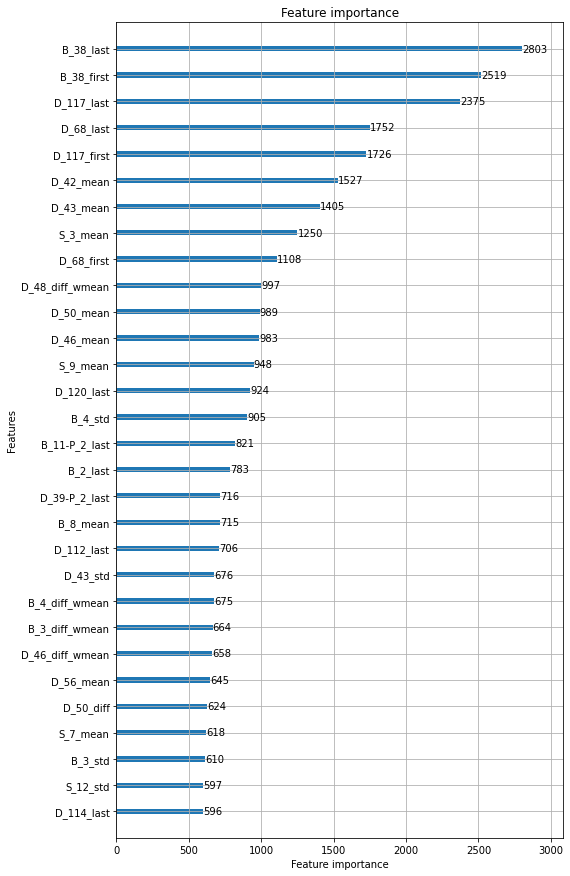

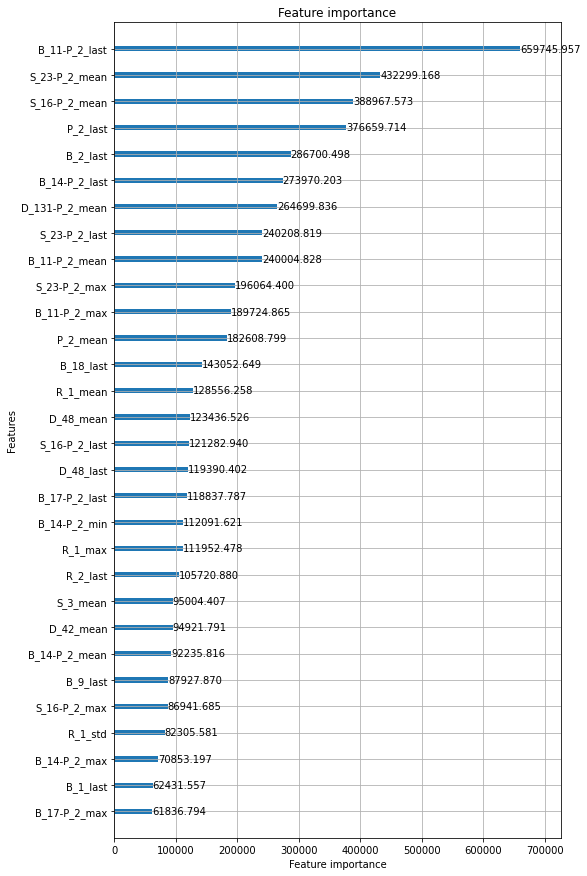

######################################## training model 2/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning

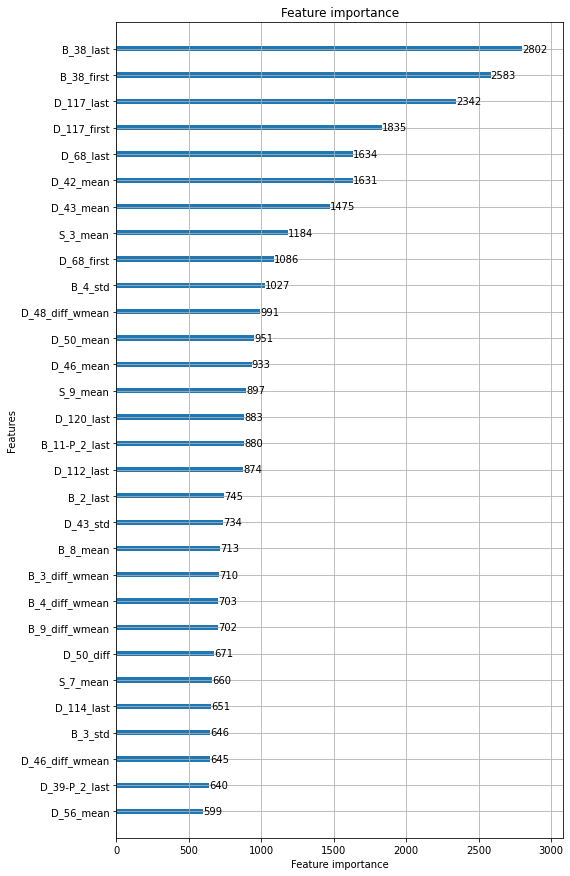

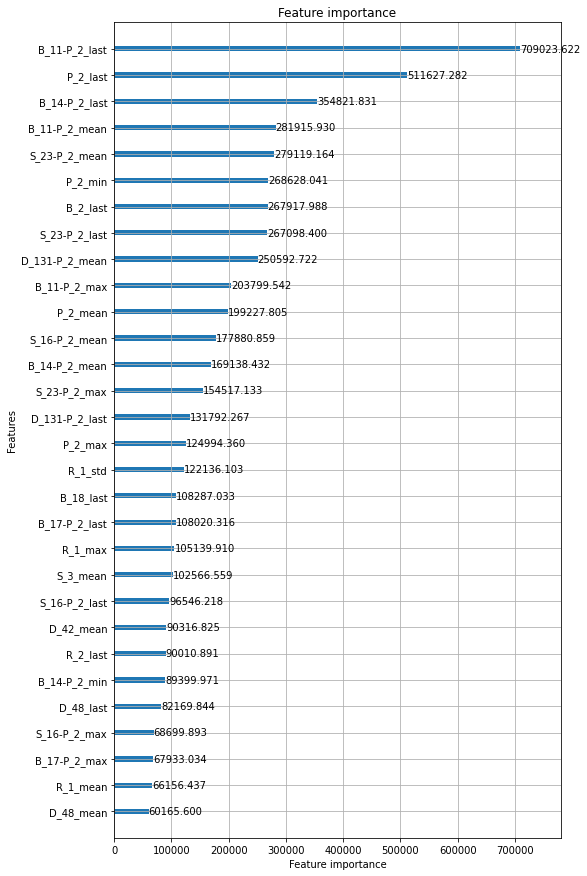

######################################## training model 3/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning

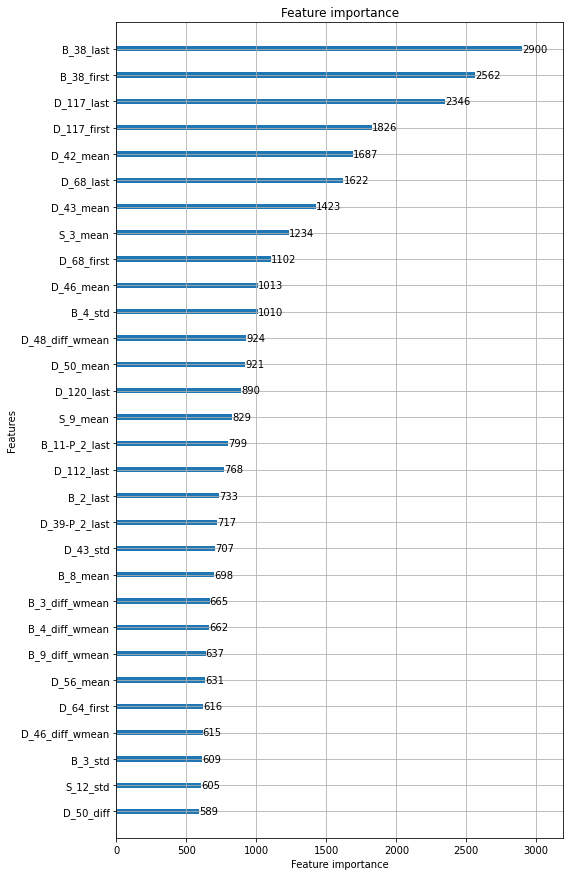

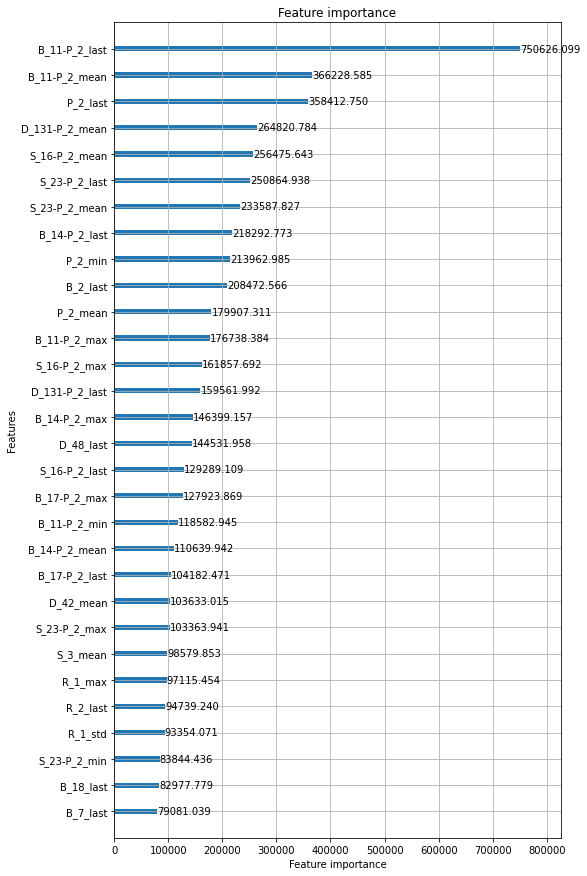

######################################## training model 4/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning

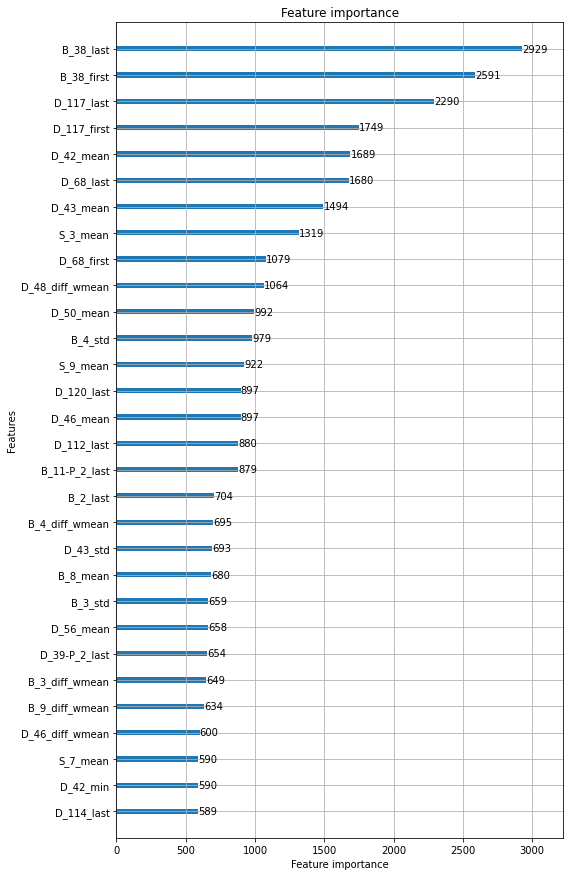

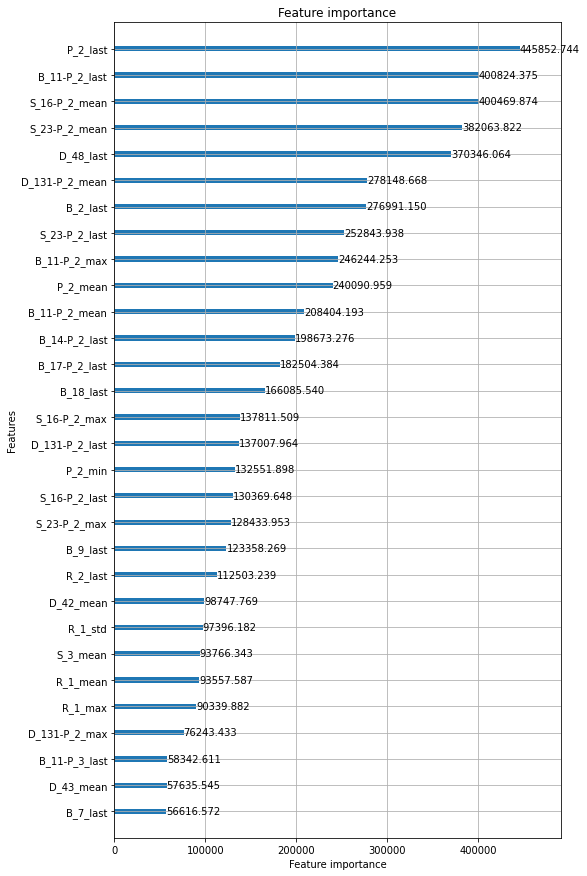

######################################## training model 5/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning

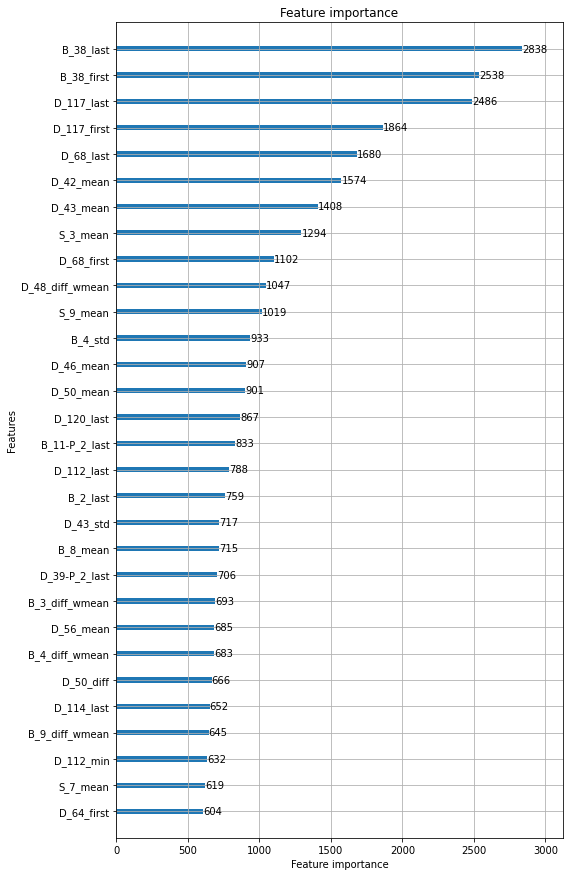

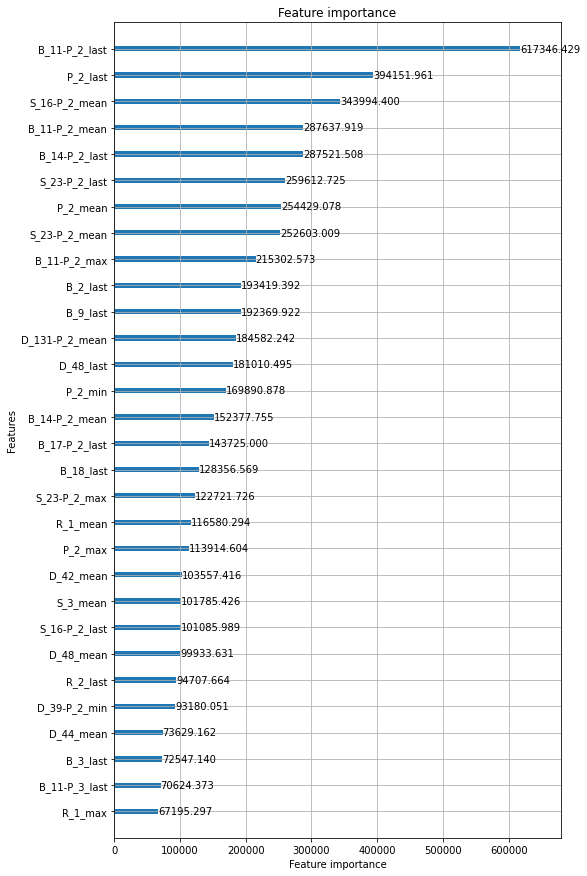

Training time: 114.01130239963531 min.
OOF recall_at4: 0.6659036590702528
OOF normalized_gini: 0.9253247854803492
OOF competition metric: 0.7956142222753011
############################### repeated cross-validation step: 2/3 ################################
######################################## training model 1/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met 

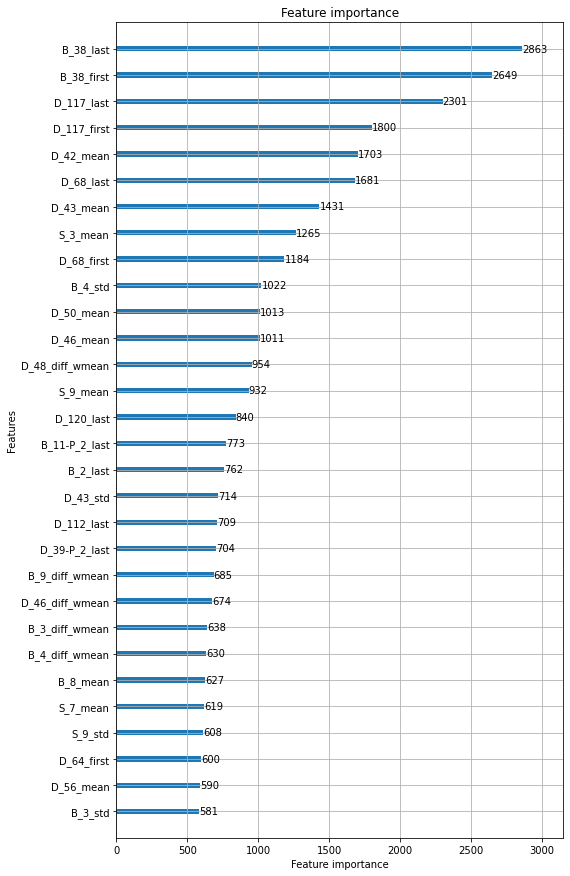

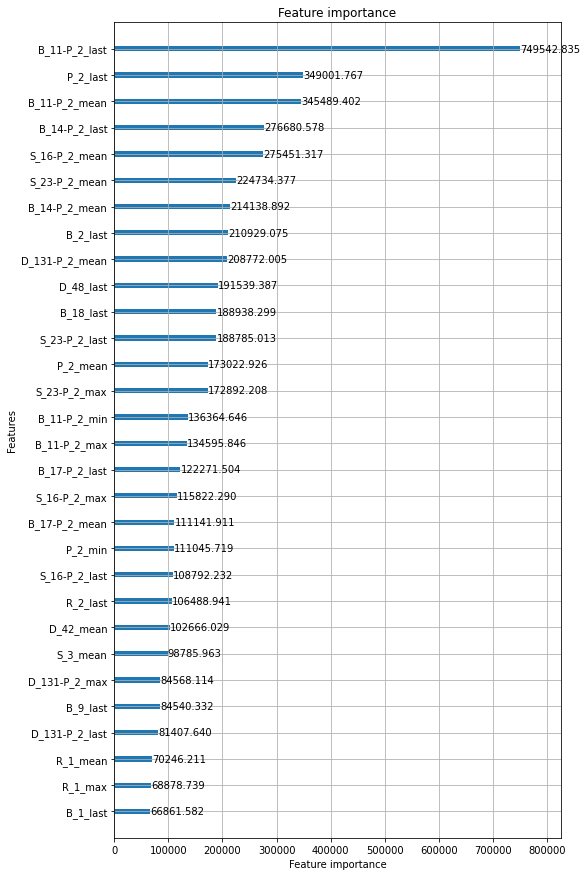

######################################## training model 2/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning

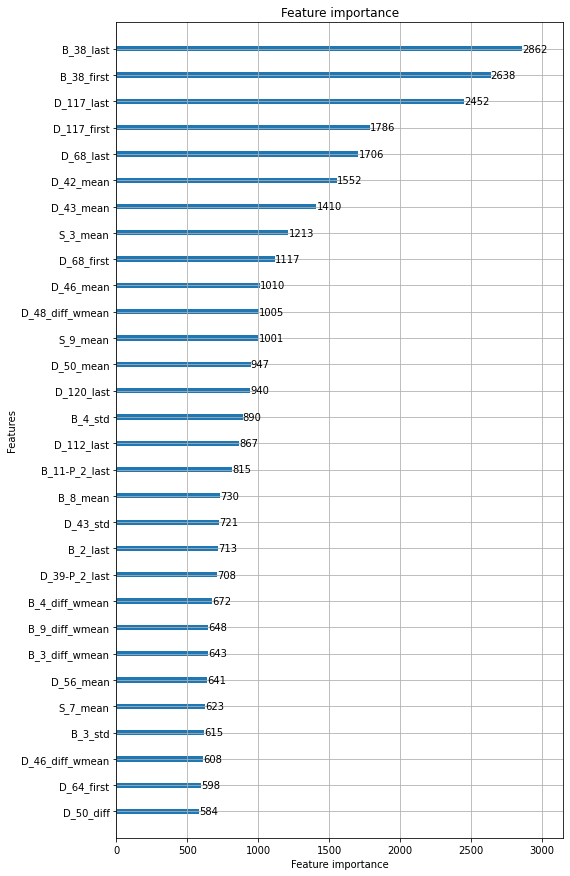

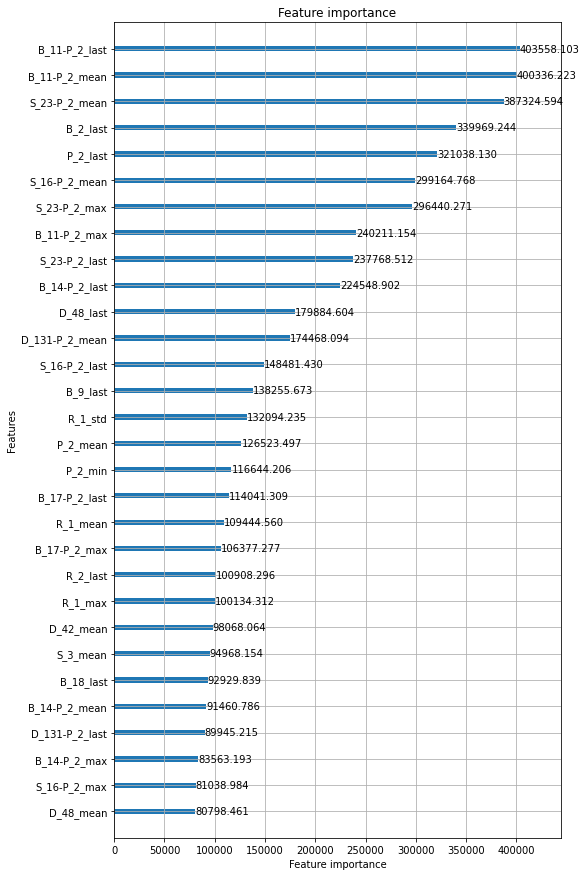

######################################## training model 3/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning

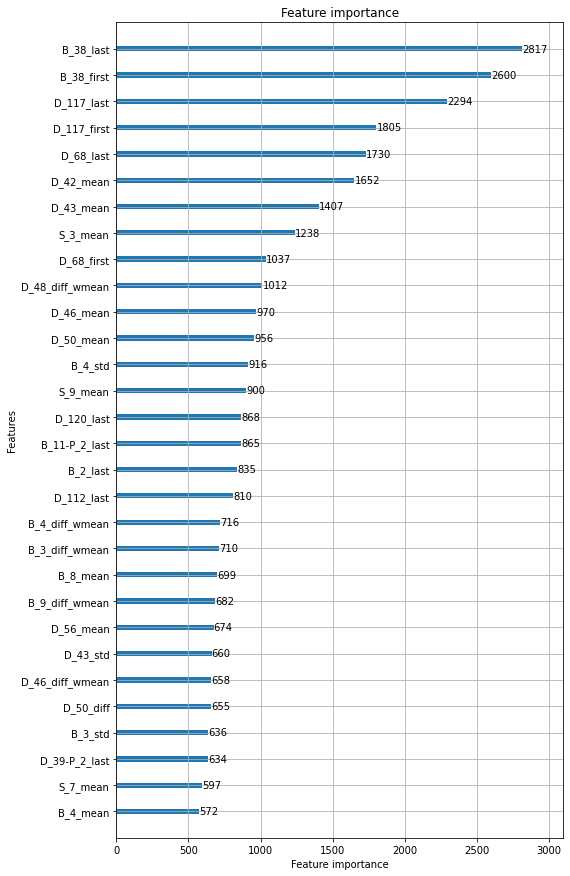

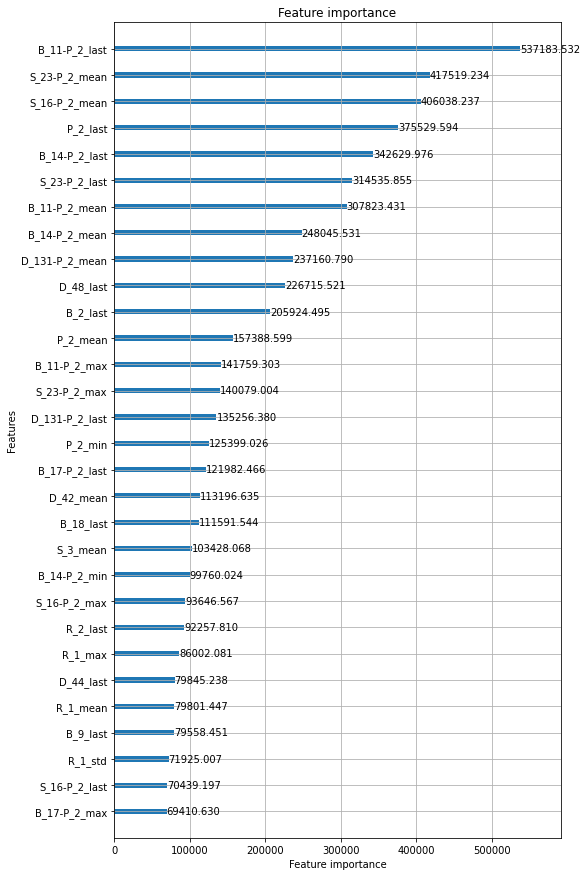

######################################## training model 4/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning

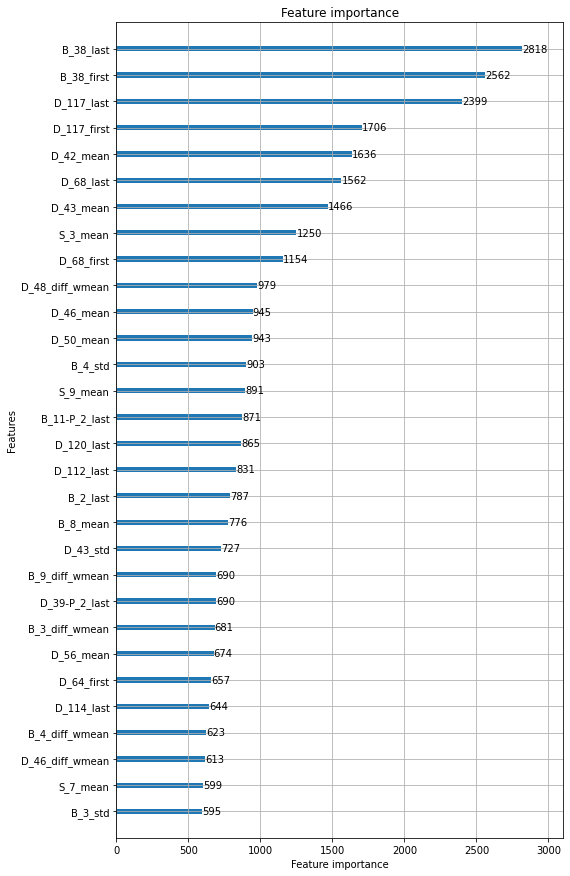

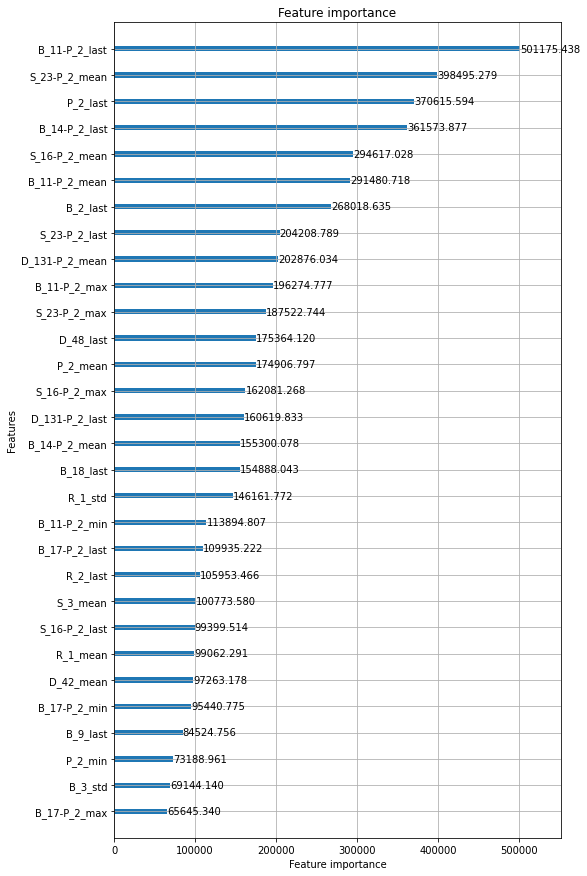

######################################## training model 5/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning

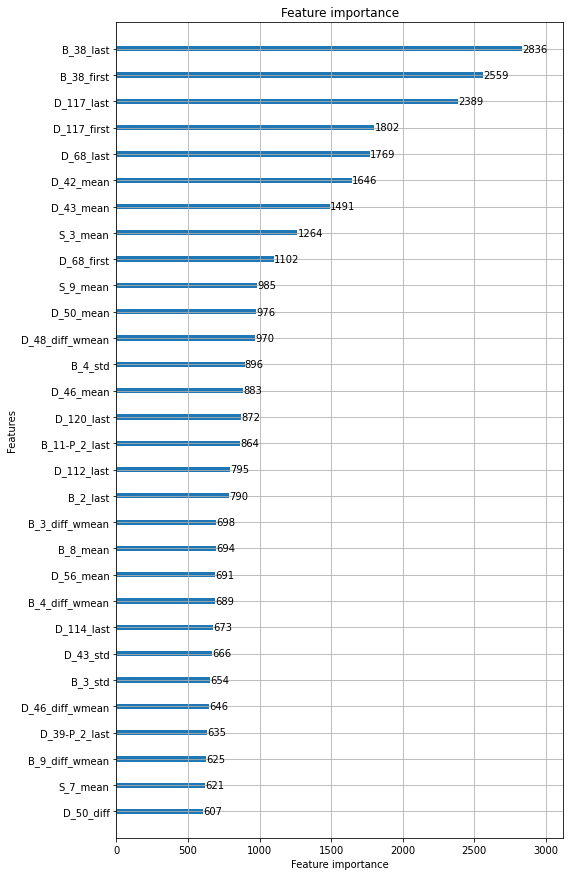

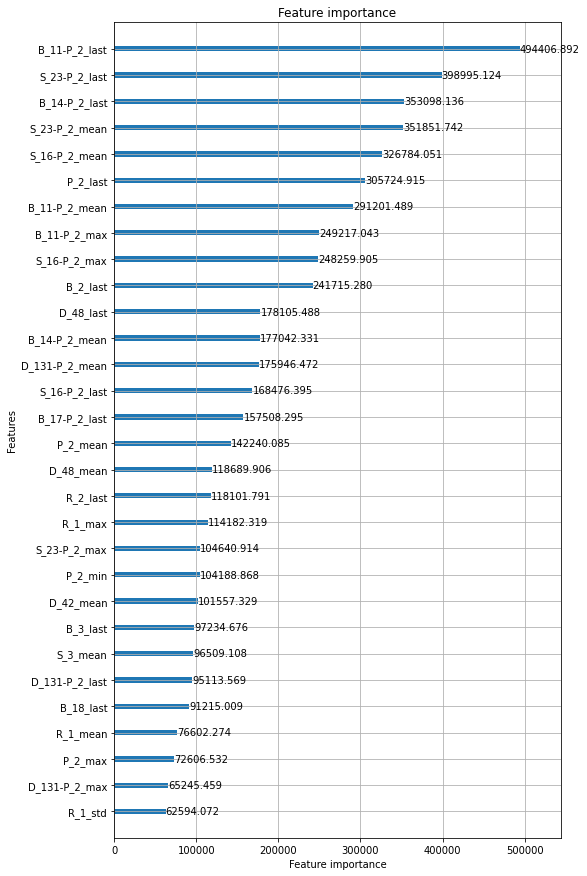

Training time: 114.0531858364741 min.
OOF recall_at4: 0.6681169421348504
OOF normalized_gini: 0.925351311339319
OOF competition metric: 0.7967341267370847
############################### repeated cross-validation step: 3/3 ################################
######################################## training model 1/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met ne

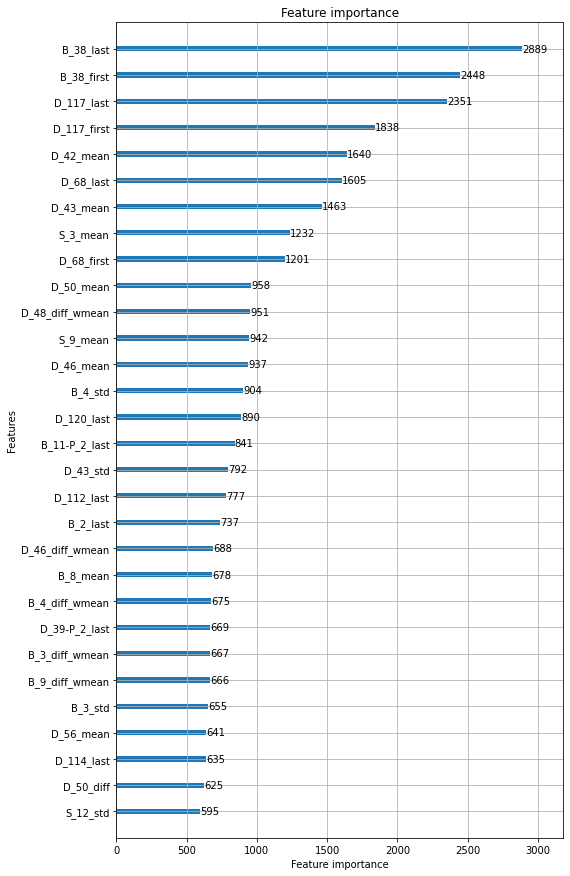

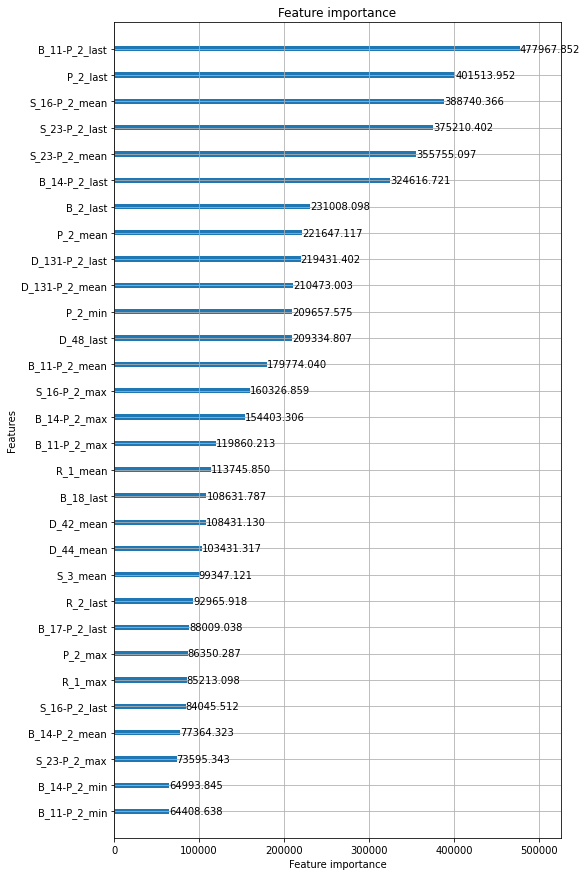

######################################## training model 2/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning

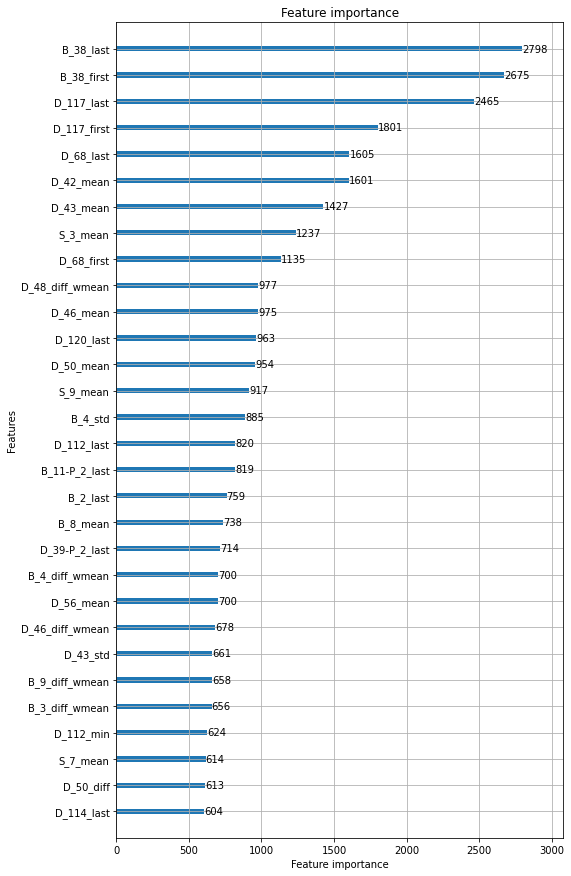

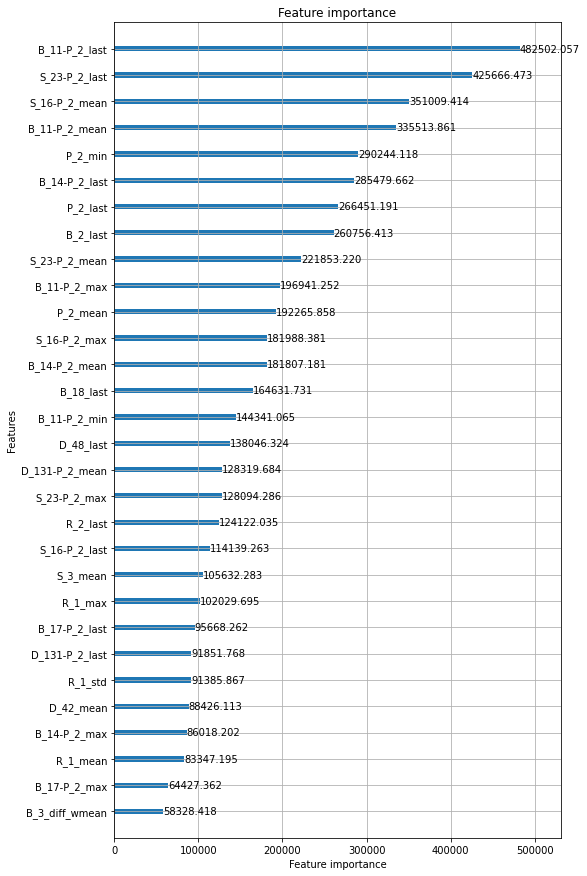

######################################## training model 3/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning

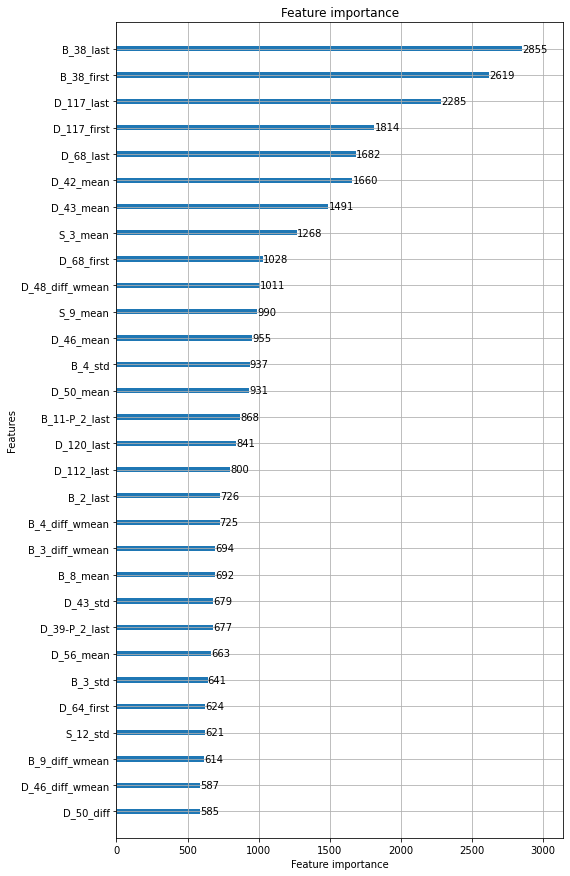

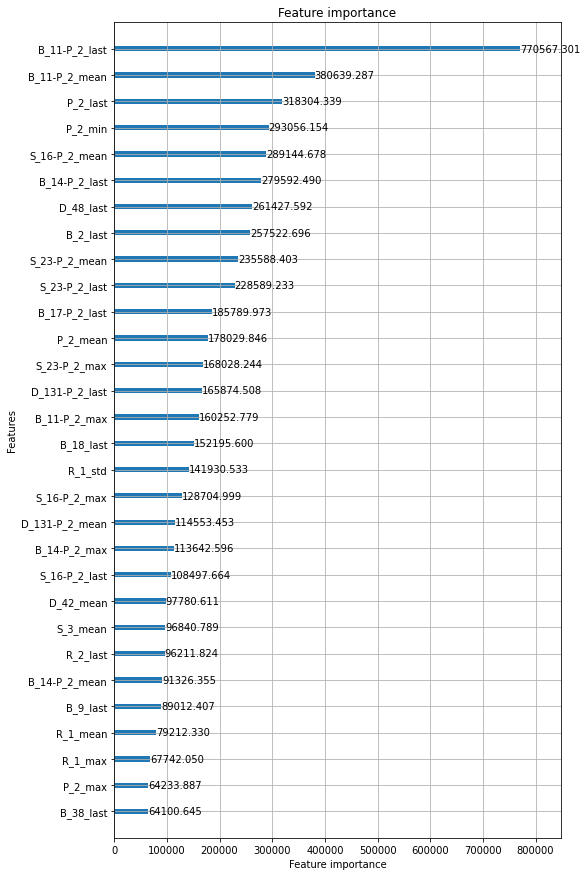

######################################## training model 4/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning

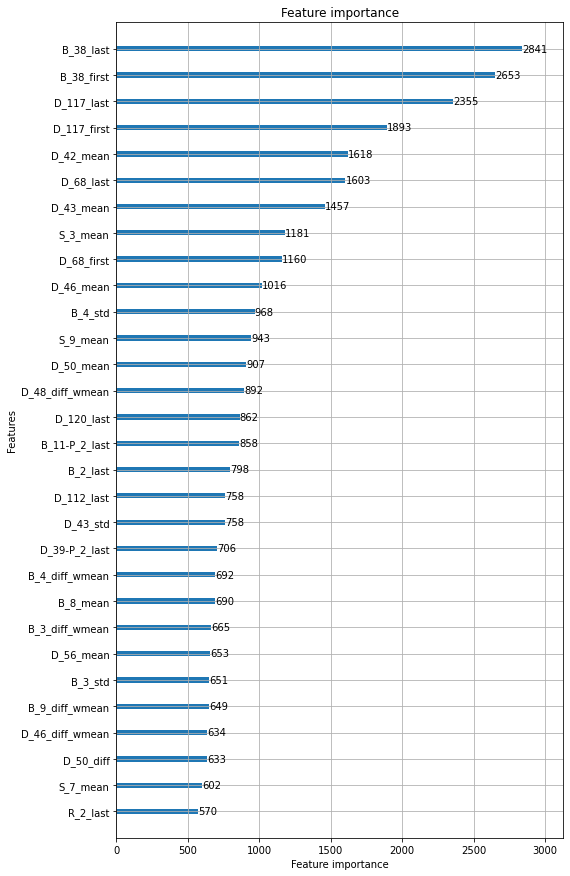

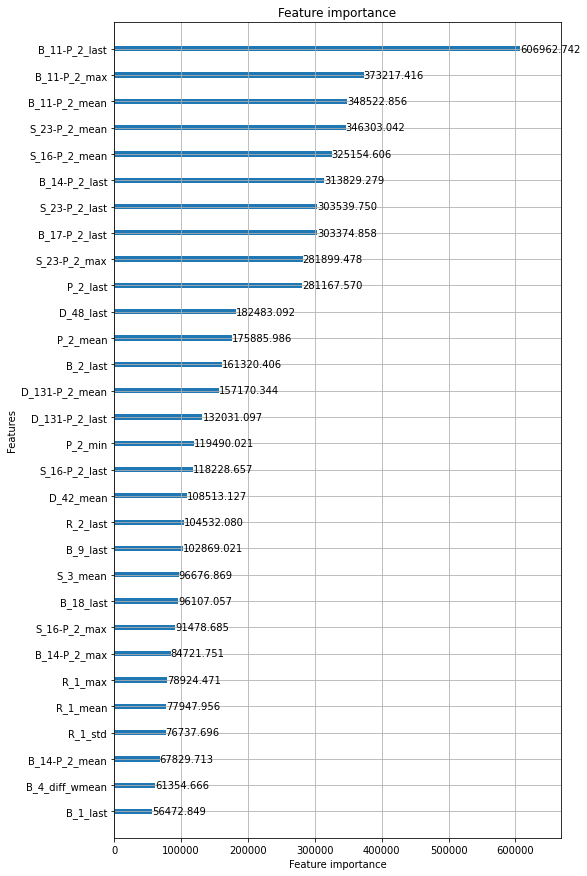

######################################## training model 5/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning

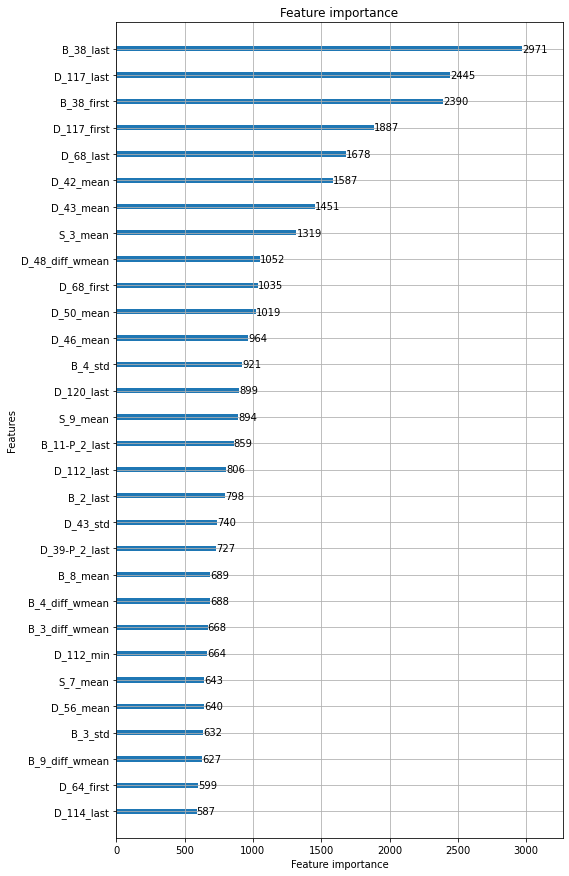

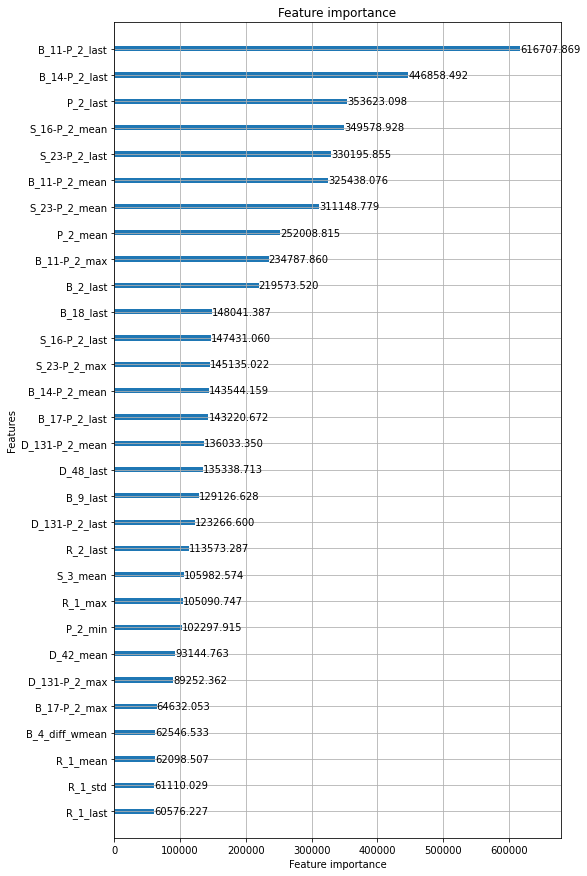

Training time: 114.12590694824854 min.
OOF recall_at4: 0.6665684855421281
OOF normalized_gini: 0.9253761385732958
OOF competition metric: 0.795972312057712
CPU times: user 3d 11h 23min 37s, sys: 2min 13s, total: 3d 11h 25min 51s
Wall time: 5h 42min 25s


In [12]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
        
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [13]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.665904,0.925325,0.795614
1,0.668117,0.925351,0.796734
2,0.666568,0.925376,0.795972



mean:


recall_at4    0.666863
gini          0.925351
metric        0.796107
dtype: float64


std:


recall_at4    0.001136
gini          0.000026
metric        0.000572
dtype: float64

In [14]:
del train, all_oof_dfs
gc.collect()

21

***
## make predictions and submit

In [15]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)       

In [16]:
test = pd.read_parquet("../data/processed/dsv02/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [17]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 3h 7min 40s, sys: 54.4 s, total: 3h 8min 35s
Wall time: 14min 43s


In [18]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.44 s, sys: 843 ms, total: 4.29 s
Wall time: 4.28 s


***